# Velocity and acceleration diagnostics

- [ ] global histogram
- [ ] 2° bins histograms store in 
- [ ] NRJ bins histograms store in 


In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
import dask.array as da

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt


import drifters.utils as ut
import pynsitu as pin

from dask.delayed import delayed

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    #cluster = PBSCluster()
    #w = cluster.scale(jobs=3) # 2 not enough for lon, lat, year, binning
    cluster = PBSCluster(cores=3, processes=3, walltime='04:00:00')
    w = cluster.scale(jobs=8)
else:
    from dask.distributed import LocalCluster
    cluster = LocalCluster()
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.203:8787/status,
Dashboard: http://10.148.0.203:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.203:50612,Workers: 0
Dashboard: http://10.148.0.203:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
root_dir = "/home1/datawork/mdemol/GDP"
parquet_argos = os.path.join(root_dir, "argos_av_time.parquet")
parquet_gps = os.path.join(root_dir, "gps_av_time.parquet")

In [4]:
df_gps = dd.read_parquet(parquet_gps).persist()
df_argos = dd.read_parquet(parquet_argos).persist()

In [6]:
df_gps

,time,id,lon,lat,vex,vny,vxy,ve,vn,ae,an,aen,aex,any,axy,typebuoy,gap,deploy_date,deploy_lat,deploy_lon,end_date,end_lat,end_lon,drogue_lost_date,typedeath,lon360,err_lat,err_lon,err_ve,err_vn
npartitions=148,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float32,float32,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,object,float64,datetime64[ns],float64,float64,datetime64[ns],float64,float64,datetime64[ns],float64,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Global histogram

In [78]:
def print_mean_var(df):
    for l in df.columns :
        print(l + f': mean = {df[l].mean().compute()}, variance = {df[l].var().compute()}, std = {df[l].std().compute()}')

In [79]:
print_mean_var(df_gps[['ve', 'vn', 'ae', 'an', 'vex', 'vny', 'aex', 'any']])

ve: mean = 0.011794044249571098, variance = 0.0628432184457779, std = 0.2506854832172394
vn: mean = 0.0033113528339724953, variance = 0.04800022020936012, std = 0.21908952295780182
ae: mean = -2.767218635963441e-10, variance = 1.4280341147867293e-10, std = 1.1950038137122113e-05
an: mean = -7.194039849104883e-10, variance = 1.4384357997304564e-10, std = 1.1993480728005763e-05
vex: mean = 0.011957733667706385, variance = 0.06443895856264234, std = 0.25384829832528394
vny: mean = -0.0010015627356488742, variance = 0.12362395520161872, std = 0.35160198406951393
aex: mean = -8.944412796126405e-10, variance = 6.241906007793556e-10, std = 2.4983806771173916e-05
any: mean = -2.009514858902962e-09, variance = 5.235646728768863e-10, std = 2.288153563196505e-05


In [80]:
print_mean_var(df_argos[['ve', 'vn', 'ae', 'an', 'vex', 'vny', 'aex', 'any']])

ve: mean = 0.005583182291101385, variance = 0.07471064478158951, std = 0.27333247661590576
vn: mean = 0.005280918545608172, variance = 0.0525890477001667, std = 0.22932301461696625
ae: mean = -5.596267706297923e-10, variance = 3.04483495199027e-10, std = 1.7449455441331887e-05
an: mean = 2.750317536421524e-11, variance = 2.323882180063487e-10, std = 1.5244284765325945e-05
vex: mean = 0.005567501588995124, variance = 0.07575240500319723, std = 0.2752315479795098
vny: mean = 0.005090686674079184, variance = 0.1401732260550757, std = 0.3743971501695435
aex: mean = -2.493054724798962e-09, variance = 2.4987916769100803e-09, std = 4.998791530870317e-05
any: mean = -4.6236329216281857e-10, variance = 1.5814457297611844e-09, std = 3.97673953102436e-05


In [26]:
da.histogram?

Signature:
da.histogram(
    a,
    bins=None,
    range=None,
    normed=False,
    weights=None,
    density=None,
)
Docstring:
Blocked variant of :func:`numpy.histogram`.

Parameters
----------
a : dask.array.Array
    Input data; the histogram is computed over the flattened
    array. If the ``weights`` argument is used, the chunks of
    ``a`` are accessed to check chunking compatibility between
    ``a`` and ``weights``. If ``weights`` is ``None``, a
    :py:class:`dask.dataframe.Series` object can be passed as
    input data.
bins : int or sequence of scalars, optional
    Either an iterable specifying the ``bins`` or the number of ``bins``
    and a ``range`` argument is required as computing ``min`` and ``max``
    over blocked arrays is an expensive operation that must be performed
    explicitly.
    If `bins` is an int, it defines the number of equal-width
    bins in the given range (10, by default). If `bins` is a
    sequence, it defines a monotonically increasing array 

In [54]:
def plot_histogram(darray ,ax, bins = np.linspace(-2, 2, 100), **kwargs):
    h, b= da.histogram(darray, bins = bins, density = True)
    ax.plot(bins[:-1]+np.diff(bins)/2, h, **kwargs)

Text(0.5, 0, 'acceleration [$m/s^2$]')

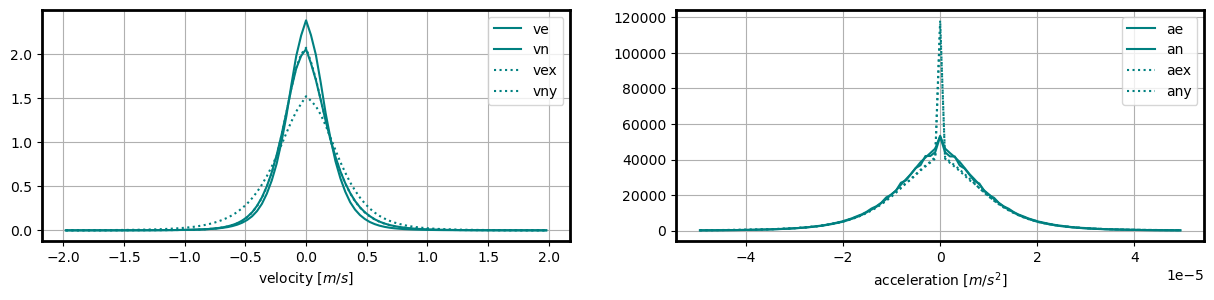

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(15,3))
axs=axs.flatten()
plot_histogram(df_gps['ve'], axs[0], color = 'teal', label = 've')
plot_histogram(df_gps['vn'], axs[0], color = 'teal', label = 'vn')
plot_histogram(df_gps['vex'], axs[0], color = 'teal', label = 'vex', ls = ':')
plot_histogram(df_gps['vny'], axs[0], color = 'teal', label = 'vny', ls = ':')
plot_histogram(df_gps['ae'], axs[1], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color = 'teal', label = 'ae')
plot_histogram(df_gps['an'], axs[1], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color ='teal', label = 'an')
plot_histogram(df_gps['aex'], axs[1], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color = 'teal', label = 'aex', ls = ':')
plot_histogram(df_gps['any'], axs[1], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color ='teal', label = 'any', ls = ':')
for ax in axs :
    ax.grid()
    ax.legend()
axs[0].set_xlabel(r'velocity [$m/s$]')
axs[1].set_xlabel(r'acceleration [$m/s^2$]')

Text(0.5, 0, 'acceleration [$m/s^2$]')

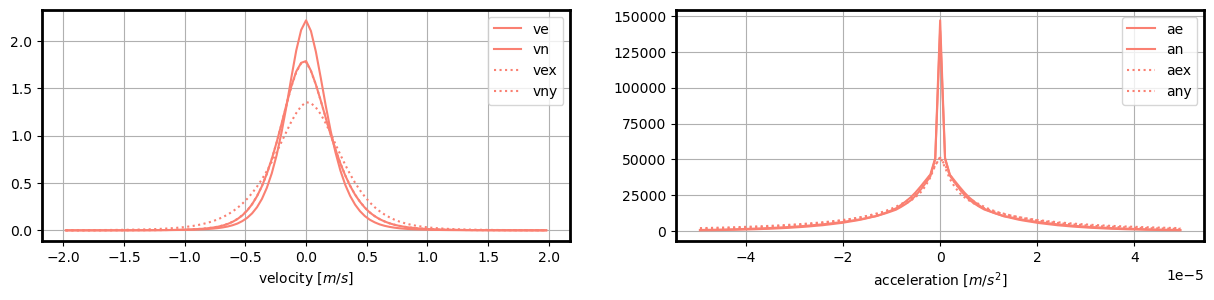

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(15,3))
axs=axs.flatten()
plot_histogram(df_argos['ve'], axs[0], color = 'salmon', label = 've')
plot_histogram(df_argos['vn'], axs[0], color = 'salmon', label = 'vn')
plot_histogram(df_argos['vex'], axs[0], color = 'salmon', label = 'vex', ls = ':')
plot_histogram(df_argos['vny'], axs[0], color = 'salmon', label = 'vny', ls = ':')
plot_histogram(df_argos['ae'], axs[1], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color = 'salmon', label = 'ae')
plot_histogram(df_argos['an'], axs[1], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color ='salmon', label = 'an')
plot_histogram(df_argos['aex'], axs[1], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color = 'salmon', label = 'aex', ls = ':')
plot_histogram(df_argos['any'], axs[1], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color ='salmon', label = 'any', ls = ':')
for ax in axs :
    ax.grid()
    ax.legend()
axs[0].set_xlabel(r'velocity [$m/s$]')
axs[1].set_xlabel(r'acceleration [$m/s^2$]')

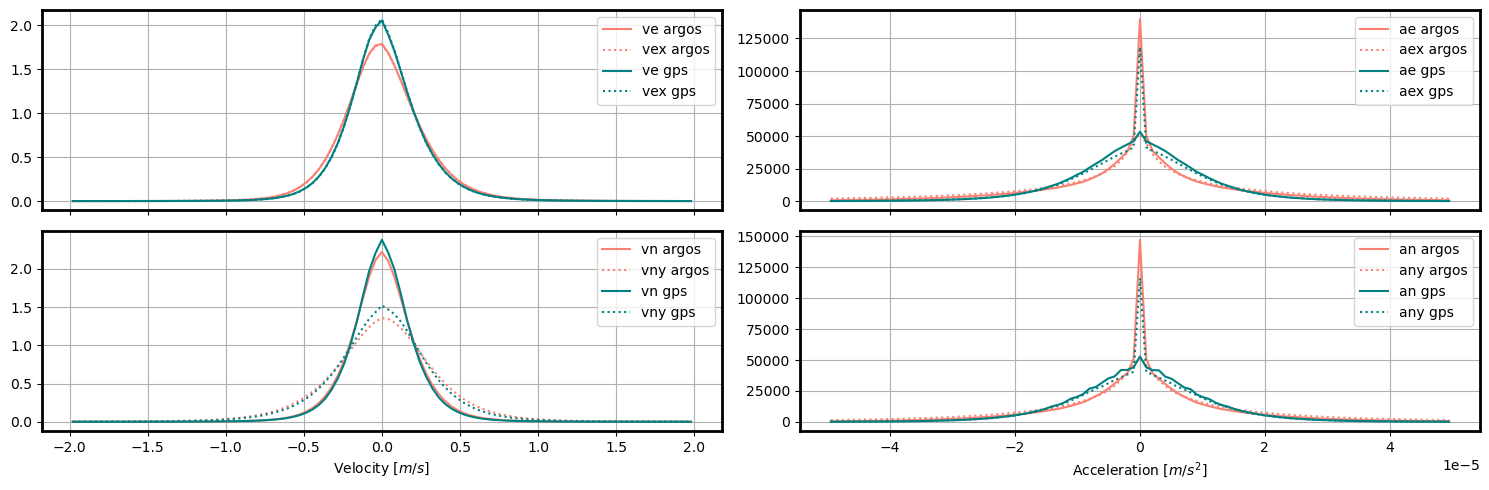

In [66]:
fig, axs = plt.subplots(2, 2, sharex='col', figsize=(15,5))
axs=axs.flatten()
plot_histogram(df_argos['ve'], axs[0], color = 'salmon', label = 've argos')
plot_histogram(df_argos['vn'], axs[2], color = 'salmon', label = 'vn argos')
plot_histogram(df_argos['vex'], axs[0], color = 'salmon', label = 'vex argos', ls = ':')
plot_histogram(df_argos['vny'], axs[2], color = 'salmon', label = 'vny argos', ls = ':')
plot_histogram(df_gps['ve'], axs[0], color = 'teal', label = 've gps')
plot_histogram(df_gps['vn'], axs[2], color = 'teal', label = 'vn gps')
plot_histogram(df_gps['vex'], axs[0], color = 'teal', label = 'vex gps', ls = ':')
plot_histogram(df_gps['vny'], axs[2], color = 'teal', label = 'vny gps', ls = ':')
plot_histogram(df_argos['ae'], axs[1], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color = 'salmon', label = 'ae argos')
plot_histogram(df_argos['an'], axs[3], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color = 'salmon', label = 'an argos')
plot_histogram(df_argos['aex'], axs[1], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color = 'salmon', label = 'aex argos', ls = ':')
plot_histogram(df_argos['any'], axs[3], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color = 'salmon', label = 'any argos', ls = ':')
plot_histogram(df_gps['ae'], axs[1], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color = 'teal', label = 'ae gps')
plot_histogram(df_gps['an'], axs[3], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color ='teal', label = 'an gps')
plot_histogram(df_gps['aex'], axs[1], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color = 'teal', label = 'aex gps', ls = ':')
plot_histogram(df_gps['any'], axs[3], bins =np.linspace(-5*1e-5, 5*1e-5, 100), color ='teal', label = 'any gps', ls = ':')
for ax in axs :
    ax.grid()
    ax.legend()
axs[2].set_xlabel(r'Velocity [$m/s$]')
axs[3].set_xlabel(r'Acceleration [$m/s^2$]')
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)

# 2° bins histograms
## Caution add count, solve pb categoricalIndex
  Store in 

In [11]:
# bin geographically
dl = 2.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90, 90, dl)
def bins_geo(df):
    df['lon'] = (df['lon']+180)%360 - 180
    df['lon_cut'] = df['lon'].map_partitions(pd.cut, bins=lon_bins).map(lambda x: x.mid)
    df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins).map(lambda x: x.mid)

bins_geo(df_gps)


In [19]:
def compute_histogram(df, key, bins = np.linspace(-3, 3, 150)):

    try :
        lon = df.reset_index()['lon_cut'].loc[0].compute().values[0]
        lat = df.reset_index()['lat_cut'].loc[0].compute().values[0]
    except : 
        lon = df.reset_index()['lon_cut'].loc[0]
        lat = df.reset_index()['lat_cut'].loc[0]
    try : 
        h, b = da.histogram(df[key], bins = bins, density = True).compute()  
    except : 
        h, b = np.histogram(df[key], bins = bins, density = True)
    index = pd.MultiIndex.from_arrays([[lon],
                                       [lat]
                                      ], 
                                      names=('lon_cut', 'lat_cut'),
                                     )
    out = pd.DataFrame(dict(zip(b[:-1]+np.diff(bins)/2, h)), index=index) #create multiindex
    if (df['lon_cut'] != lon).any() or (df['lat_cut'] != lat).any():
        assert False, 'pb with lon, lat groupby'
    return out

In [66]:
df = df_gps.get_partition(0).groupby(['lon_cut', 'lat_cut']).get_group((-95, 5.0))

In [69]:
hist_ve = compute_histogram(df.compute(), 've')

-95.0 5.0
<class 'pandas.core.series.Series'>


In [70]:
hist_ve

,,-2.979866,-2.939597,-2.899329,-2.859060,-2.818792,-2.778523,-2.738255,-2.697987,-2.657718,-2.617450,...,2.617450,2.657718,2.697987,2.738255,2.778523,2.818792,2.859060,2.899329,2.939597,2.979866
lon_cut,lat_cut,,,,,,,,,,,,,,,,,,,,,
-95.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
def build_geo_hist(df, v_bins = np.linspace(-2.5, 2.5, 150), a_bins = np.linspace(-2.5e-5, 2.5e-5, 150), v_keys = ['ve', 'vn', 'vex', 'vny'], a_keys = ['ae', 'an', 'aex', 'any']):
    if 'lon_cut' not in df.columns or 'lat_cut' not in df.columns :
        bins_geo(df)        
    ds = xr.Dataset()
    #nb counts
    #_ds_count = df.groupby(['lon_cut', 'lat_cut']).size().to_frame('nb_geobins').compute().to_xarray().rename({'lon_cut':'lon_bins', 'lat_cut' : 'lat_bins'})
    #ds = xr.merge([ds, _ds_count]) 
    #'method' is not supported when indexing using a CategoricalIndex -> need to convert index
    
    # Velocities Histograms
    _df = df.get_partition(0).groupby(['lon_cut', 'lat_cut']).get_group((-95, 5.0))
    _histv = compute_histogram(_df.compute(), v_keys[0], v_bins)
    _hista = compute_histogram(_df.compute(), a_keys[0], a_bins)

    for v in v_keys :
        if v not in df.columns : 
            print(f'{v} not in dataframe')
            continue
        hv = df.groupby(['lon_cut', 'lat_cut']).apply(compute_histogram, v, v_bins, meta = _histv).compute()
        _ds = (pd.melt(da.reset_index(), id_vars=['lon_cut', 'lat_cut',], var_name='vbins',).rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'hist_'+v})
             ).to_xarray().set_index(index=['lon_bins', 'lat_bins','vbins']).unstack()
        _ds['vbins'] = _ds['vbins'].astype(float)#convert object type to float
        ds = xr.merge([ds, _ds])
        print(v)
    # Accelerations Histograms    
    for a in a_keys :
        if a not in df.columns : 
            print(f'{a} not in dataframe')
            continue
        hv = df.groupby(['lon_cut', 'lat_cut']).apply(compute_histogram, a, a_bins, meta = _hista).compute()
        _ds = (pd.melt(da.reset_index(), id_vars=['lon_cut', 'lat_cut',], var_name='abins',).rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'hist_'+a})
             ).to_xarray().set_index(index=['lon_bins', 'lat_bins','abins']).unstack()
        _ds['abins'] = _ds['abins'].astype(float)#convert object type to float
        ds = xr.merge([ds, _ds])
        print(a)
         
    return ds
        

In [105]:
Hv = build_geo_hist(df_gps)

-95.0 5.0
<class 'pandas.core.series.Series'>
-95.0 5.0
<class 'pandas.core.series.Series'>
ve
vn
vex
vny
ae
an
aex
any


In [107]:
Hv

<xarray.Dataset>
Dimensions:   (lon_bins: 179, lat_bins: 84, vbins: 149, abins: 149)
Coordinates:
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins  (lat_bins) float64 -79.0 -77.0 -75.0 -73.0 ... 81.0 83.0 85.0 87.0
  * vbins     (vbins) float64 -2.98 -2.94 -2.899 -2.859 ... 2.899 2.94 2.98
  * abins     (abins) float64 -2.98 -2.94 -2.899 -2.859 ... 2.899 2.94 2.98
Data variables:
    hist_ve   (lon_bins, lat_bins, vbins) float64 nan nan nan ... nan nan nan
    hist_vn   (lon_bins, lat_bins, vbins) float64 nan nan nan ... nan nan nan
    hist_vex  (lon_bins, lat_bins, vbins) float64 nan nan nan ... nan nan nan
    hist_vny  (lon_bins, lat_bins, vbins) float64 nan nan nan ... nan nan nan
    hist_ae   (lon_bins, lat_bins, abins) float64 nan nan nan ... nan nan nan
    hist_an   (lon_bins, lat_bins, abins) float64 nan nan nan ... nan nan nan
    hist_aex  (lon_bins, lat_bins, abins) float64 nan nan nan ... nan nan nan
    hist_any  (lon_bins, lat_bins, abins) float64 nan nan nan ... nan nan nan

## Store

## Visualisation

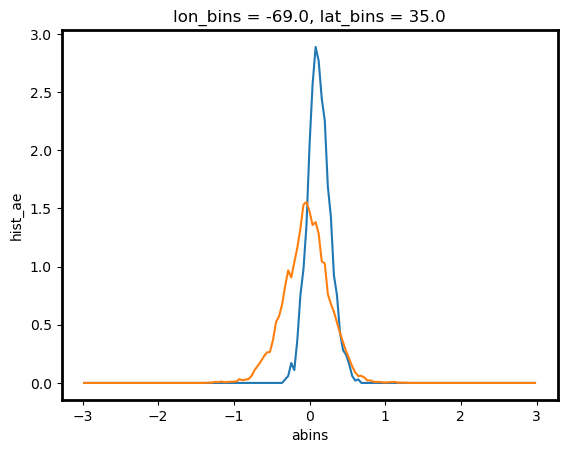

In [111]:
Hv.hist_ae.sel(lon_bins = 0 , lat_bins =-40, method='nearest').plot()
Hv.hist_ae.sel(lon_bins = -70 , lat_bins =35, method='nearest').plot()

In [54]:
da = Hv['ve']
ds = (pd.melt(da.reset_index(), id_vars=['lon_cut', 'lat_cut',], var_name='vbins',).rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'hist_'+'ve'})
         ).to_xarray().set_index(index=['lon_bins', 'lat_bins','vbins']).unstack()
ds

<xarray.Dataset>
Dimensions:   (lon_bins: 179, lat_bins: 84, vbins: 149)
Coordinates:
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins  (lat_bins) float64 -79.0 -77.0 -75.0 -73.0 ... 81.0 83.0 85.0 87.0
  * vbins     (vbins) object -2.9798657718120802 ... 2.9798657718120802
Data variables:
    hist_ve   (lon_bins, lat_bins, vbins) float64 nan nan nan ... nan nan nan

In [40]:
pd.melt(da.to_xarray()

<xarray.Dataset>
Dimensions:                 (lon_cut: 179, lat_cut: 84)
Coordinates:
  * lon_cut                 (lon_cut) float64 -179.0 -177.0 ... 175.0 177.0
  * lat_cut                 (lat_cut) float64 -79.0 -77.0 -75.0 ... 85.0 87.0
Data variables: (12/149)
    -2.9798657718120802     (lon_cut, lat_cut) float64 nan 0.0 0.0 ... 0.0 nan
    -2.9395973154362416     (lon_cut, lat_cut) float64 nan 0.0 0.0 ... 0.0 nan
    -2.899328859060403      (lon_cut, lat_cut) float64 nan 0.0 0.0 ... 0.0 nan
    -2.859060402684564      (lon_cut, lat_cut) float64 nan 0.0 0.0 ... 0.0 nan
    -2.8187919463087248     (lon_cut, lat_cut) float64 nan 0.0 0.0 ... 0.0 nan
    -2.778523489932886      (lon_cut, lat_cut) float64 nan 0.0 0.0 ... 0.0 nan
    ...                      ...
    2.7785234899328857      (lon_cut, lat_cut) float64 nan 0.0 0.0 ... 0.0 nan
    2.8187919463087243      (lon_cut, lat_cut) float64 nan 0.0 0.0 ... 0.0 nan
    2.8590604026845634      (lon_cut, lat_cut) float64 nan 0.0 0.0 ... 0.0 nan
    2.8993288590604025      (lon_cut, lat_cut) float64 nan 0.0 0.0 ... 0.0 nan
    2.939597315436241       (lon_cut, lat_cut) float64 nan 0.0 0.0 ... 0.0 nan
    2.9798657718120802      (lon_cut, lat_cut) float64 nan 0.0 0.0 ... 0.0 nan

In [71]:
hist_ve = compute_histogram(df.compute(), 've')
df_group_gps = df_gps.groupby(['lon_cut', 'lat_cut'])
df_out = df_group_gps.apply(compute_histogram, 've', meta = hist_ve).persist()
df_out

,-2.979866e+00,-2.939597e+00,-2.899329e+00,-2.859060e+00,-2.818792e+00,-2.778523e+00,-2.738255e+00,-2.697987e+00,-2.657718e+00,-2.617450e+00,-2.577181e+00,-2.536913e+00,-2.496644e+00,-2.456376e+00,-2.416107e+00,-2.375839e+00,-2.335570e+00,-2.295302e+00,-2.255034e+00,-2.214765e+00,-2.174497e+00,-2.134228e+00,-2.093960e+00,-2.053691e+00,-2.013423e+00,-1.973154e+00,-1.932886e+00,-1.892617e+00,-1.852349e+00,-1.812081e+00,-1.771812e+00,-1.731544e+00,-1.691275e+00,-1.651007e+00,-1.610738e+00,-1.570470e+00,-1.530201e+00,-1.489933e+00,-1.449664e+00,-1.409396e+00,-1.369128e+00,-1.328859e+00,-1.288591e+00,-1.248322e+00,-1.208054e+00,-1.167785e+00,-1.127517e+00,-1.087248e+00,-1.046980e+00,-1.006711e+00,-9.664430e-01,-9.261745e-01,-8.859060e-01,-8.456376e-01,-8.053691e-01,-7.651007e-01,-7.248322e-01,-6.845638e-01,-6.442953e-01,-6.040268e-01,-5.637584e-01,-5.234899e-01,-4.832215e-01,-4.429530e-01,-4.026846e-01,-3.624161e-01,-3.221477e-01,-2.818792e-01,-2.416107e-01,-2.013423e-01,-1.610738e-01,-1.208054e-01,-8.053691e-02,-4.026846e-02,-2.220446e-16,4.026846e-02,8.053691e-02,1.208054e-01,1.610738e-01,2.013423e-01,2.416107e-01,2.818792e-01,3.221477e-01,3.624161e-01,4.026846e-01,4.429530e-01,4.832215e-01,5.234899e-01,5.637584e-01,6.040268e-01,6.442953e-01,6.845638e-01,7.248322e-01,7.651007e-01,8.053691e-01,8.456376e-01,8.859060e-01,9.261745e-01,9.664430e-01,1.006711e+00,1.046980e+00,1.087248e+00,1.127517e+00,1.167785e+00,1.208054e+00,1.248322e+00,1.288591e+00,1.328859e+00,1.369128e+00,1.409396e+00,1.449664e+00,1.489933e+00,1.530201e+00,1.570470e+00,1.610738e+00,1.651007e+00,1.691275e+00,1.731544e+00,1.771812e+00,1.812081e+00,1.852349e+00,1.892617e+00,1.932886e+00,1.973154e+00,2.013423e+00,2.053691e+00,2.093960e+00,2.134228e+00,2.174497e+00,2.214765e+00,2.255034e+00,2.295302e+00,2.335570e+00,2.375839e+00,2.416107e+00,2.456376e+00,2.496644e+00,2.536913e+00,2.577181e+00,2.617450e+00,2.657718e+00,2.697987e+00,2.738255e+00,2.778523e+00,2.818792e+00,2.859060e+00,2.899329e+00,2.939597e+00,2.979866e+00
npartitions=148,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,

In [72]:
df_out.compute()

-2.979866  -2.939597  -2.899329  -2.859060  -2.818792  \
lon_cut lat_cut                                                          
-179.0   49.0          0.0        0.0        0.0        0.0        0.0   
-169.0  -65.0          0.0        0.0        0.0        0.0        0.0   
-163.0  -61.0          0.0        0.0        0.0        0.0        0.0   
-153.0   81.0          0.0        0.0        0.0        0.0        0.0   
-149.0  -7.0           0.0        0.0        0.0        0.0        0.0   
...                    ...        ...        ...        ...        ...   
 169.0  -39.0          0.0        0.0        0.0        0.0        0.0   
 171.0   3.0           0.0        0.0        0.0        0.0        0.0   
         75.0          0.0        0.0        0.0        0.0        0.0   
 173.0  -13.0          0.0        0.0        0.0        0.0        0.0   
 175.0  -67.0          0.0        0.0        0.0        0.0        0.0   

                 -2.778523  -2.738255  -2.697987  -2.657718  -2.617450  ...  \
lon_cut lat_cut                                                         ...   
-179.0   49.0          0.0        0.0        0.0        0.0        0.0  ...   
-169.0  -65.0          0.0        0.0        0.0        0.0        0.0  ...   
-163.0  -61.0          0.0        0.0        0.0        0.0        0.0  ...   
-153.0   81.0          0.0        0.0        0.0        0.0        0.0  ...   
-149.0  -7.0           0.0        0.0        0.0        0.0        0.0  ...   
...                    ...        ...        ...        ...        ...  ...   
 169.0  -39.0          0.0        0.0        0.0        0.0        0.0  ...   
 171.0   3.0           0.0        0.0        0.0        0.0        0.0  ...   
         75.0          0.0        0.0        0.0        0.0        0.0  ...   
 173.0  -13.0          0.0        0.0        0.0        0.0        0.0  ...   
 175.0  -67.0          0.0        0.0        0.0        0.0        0.0  ...   

                  2.617450   2.657718   2.697987   2.738255   2.778523  \
lon_cut lat_cut                                                          
-179.0   49.0          0.0        0.0        0.0        0.0        0.0   
-169.0  -65.0          0.0        0.0        0.0        0.0        0.0   
-163.0  -61.0          0.0        0.0        0.0        0.0        0.0   
-153.0   81.0          0.0        0.0        0.0        0.0        0.0   
-149.0  -7.0           0.0        0.0        0.0        0.0        0.0   
...                    ...        ...        ...        ...        ...   
 169.0  -39.0          0.0        0.0        0.0        0.0        0.0   
 171.0   3.0           0.0        0.0        0.0        0.0        0.0   
         75.0          0.0        0.0        0.0        0.0        0.0   
 173.0  -13.0          0.0        0.0        0.0        0.0        0.0   
 175.0  -67.0          0.0        0.0        0.0        0.0        0.0   

                  2.818792   2.859060   2.899329   2.939597   2.979866  
lon_cut lat_cut                                                         
-179.0   49.0          0.0        0.0        0.0        0.0        0.0  
-169.0  -65.0          0.0        0.0        0.0        0.0        0.0  
-163.0  -61.0          0.0        0.0        0.0        0.0        0.0  
-153.0   81.0          0.0        0.0        0.0        0.0        0.0  
-149.0  -7.0           0.0        0.0        0.0        0.0        0.0  
...                    ...        ...        ...        ...        ...  
 169.0  -39.0          0.0        0.0        0.0        0.0        0.0  
 171.0   3.0           0.0        0.0        0.0        0.0        0.0  
         75.0          0.0        0.0        0.0        0.0        0.0  
 173.0  -13.0          0.0        0.0        0.0        0.0        0.0  
 175.0  -67.0          0.0        0.0        0.0        0.0        0.0  

[9323 rows x 149 columns]

In [11]:
df

,id,lon,lat,vex,vny,vxy,ve,vn,ae,an,aen,aex,any,axy,typebuoy,gap,deploy_date,deploy_lat,deploy_lon,end_date,end_lat,end_lon,drogue_lost_date,typedeath,lon360,err_lat,err_lon,err_ve,err_vn,lon_cut,lat_cut
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float32,float32,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,object,float64,datetime64[ns],float64,float64,datetime64[ns],float64,float64,datetime64[ns],float64,float32,float32,float32,float32,float32,category[known],category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [16]:
DF = Df_chunked
DF_geo = {}
Ds = {}
for l in DF :
    DF[l]['lon'] = (DF[l]['lon']+180)%360 - 180
    DF[l]['lon_cut'] = DF[l]['lon'].map_partitions(pd.cut, bins=lon_bins)
    DF[l]['lat_cut'] = DF[l]['lat'].map_partitions(pd.cut, bins=lat_bins)
    DF_geo[l] = DF[l].groupby(['lon_cut', 'lat_cut']).mean().compute()

    #Converting pandas dataframe in xarray dataset:
    index = pd.MultiIndex.from_arrays([DF_geo[l].index.map(lambda v: v[0].mid),
                                       DF_geo[l].index.map(lambda v: v[1].mid)
                                      ], 
                                      names=('lon_cut', 'lat_cut'),
                                     )
    ds = (pd.melt(DF_geo[l].set_index(index)
                  .drop(columns=['id', 'lon','lat'])
                  .reset_index(), id_vars=['lon_cut', 'lat_cut',],
                  var_name='frequency',
                 )
          .rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'E_'+l})
         ).to_xarray().set_index(index=['lon_bins', 'lat_bins','frequency']).unstack()
    ds['frequency'] = ds['frequency'].astype(float)
    ds = ds.sortby('frequency')
    #ds = ds.chunk({'frequency': 100})
    Ds[l]=ds
    print(l)

CRSError: Invalid projection: +proj=aeqd +lat_0=nan +lon_0=nan +datum=WGS84 +units=m +type=crs: (Internal Proj Error: proj_create: invalid value for lat_0)

## Trajectories

In [7]:
grp_id = df_gps.get_partition(0).groupby('id').get_group(22192).set_index('time').compute()

In [8]:
grp_id.head()

,lon,lat,id,ve,vn,x,y,ux,uy,velocity,...,typedeath,lon360,err_lat,err_lon,err_ve,err_vn,ae-ax,an-ay,ve-ux,vn-uy
time,,,,,,,,,,,,,,,,,,,,,
2001-07-01 02:00:00,-94.795609,5.53791,22192,0.6460,-0.2900,0.000000,0.000000,NaN,NaN,NaN,...,3.0,265.204376,0.00052,0.00052,0.0100,0.0100,NaN,NaN,NaN,NaN
2001-07-01 03:00:00,-94.774597,5.52852,22192,0.6466,-0.2901,2328.165360,-1038.334652,0.649776,-0.294098,0.713234,...,3.0,265.225403,0.00052,0.00052,0.0134,0.0134,-0.000002,0.000004,-0.003176,0.003998
2001-07-01 04:00:00,-94.753387,5.51876,22192,0.6440,-0.2925,4678.387112,-2117.504284,0.656843,-0.308824,0.725820,...,3.0,265.246613,0.00065,0.00065,0.0135,0.0135,-0.000002,0.000001,-0.012843,0.016324
2001-07-01 05:00:00,-94.731918,5.50841,22192,0.6368,-0.2986,7057.436407,-3261.867565,0.660741,-0.317713,0.733158,...,3.0,265.268066,0.00059,0.00059,0.0122,0.0122,-0.000002,-0.000002,-0.023941,0.019113
2001-07-01 06:00:00,-94.710457,5.49807,22192,0.6296,-0.3047,9435.722447,-4405.037660,0.660764,-0.317528,0.733098,...,3.0,265.289551,0.00053,0.00053,0.0109,0.0109,-0.000002,-0.000002,-0.031164,0.012828


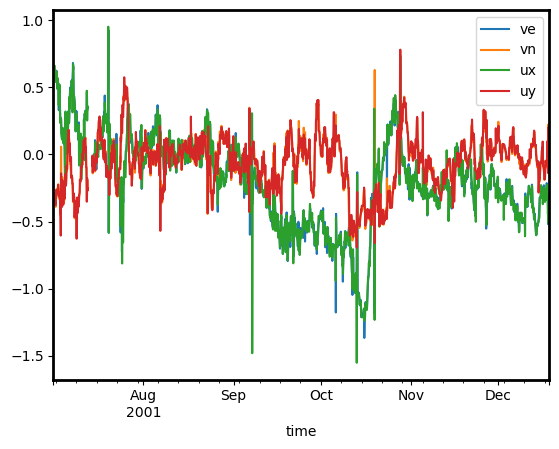

In [9]:
grp_id['ve'].plot(label = 've')
grp_id['vn'].plot(label = 'vn')
grp_id['ux'].plot(label = 'ux')
grp_id['uy'].plot(label = 'uy')
plt.legend()

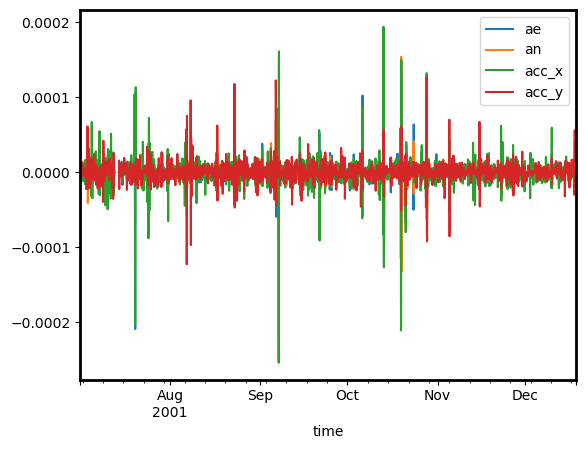

In [11]:
grp_id['ae'].plot(label = 'ae')
grp_id['an'].plot(label = 'an')
grp_id['acc_x'].plot(label = 'acc_x')
grp_id['acc_y'].plot(label = 'acc_y')
plt.legend()

## Diff derivation dependance on x,y

In [22]:
def deriv_dep2_x(df):
    xmin = (df["x"].min()).compute()
    xmax = (df["x"].max()).compute()
    df['ae-ax/ae']=df['ae-ax']/df['ae']
    df['an-ay/an']=df['an-ay']/df['an']
    df['ve-ux/ve']=df['ve-ux']/df['ve']
    df['vn-uy/vn']=df['vn-uy']/df['vn']
    #delta_gap = (gap_min - t_start)/pd.Timedelta('1H')
    xbins = np.arange(xmin, xmax, 500) # 10min binning
    df['xcut'] = df["x"].map_partitions(pd.cut, xbins)
    mean = (df[['ae-ax', 'an-ay', 've-ux', 'vn-uy','ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']]
         .groupby(df.xcut)
         .mean()
         .compute()
         .rename(columns={l:'mean_'+ l for l in ['ae-ax', 'an-ay', 've-ux', 'vn-uy','ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']})
         #.to_frame() ALREADY A DATAFRAME
        )
    mean['x'] = mean.index.to_series().apply(lambda d: d.mid)
    mean = mean.set_index('x')

    ds = (mean
          #.drop(columns=["year",])
          .to_xarray()
         )
    return ds

In [23]:
def deriv_dep2_y(df):
    xmin = (df["y"].min()).compute()
    xmax = (df["y"].max()).compute()
    df['ae-ax/ae']=df['ae-ax']/df['ae']
    df['an-ay/an']=df['an-ay']/df['an']
    df['ve-ux/ve']=df['ve-ux']/df['ve']
    df['vn-uy/vn']=df['vn-uy']/df['vn']
    #delta_gap = (gap_min - t_start)/pd.Timedelta('1H')
    xbins = np.arange(xmin, xmax, 500) # 10min binning
    df['ycut'] = df["y"].map_partitions(pd.cut, xbins)
    mean = (df[['ae-ax', 'an-ay', 've-ux', 'vn-uy','ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']]
         .groupby(df.ycut)
         .mean()
         .compute()
         .rename(columns={l:'mean_'+ l for l in ['ae-ax', 'an-ay', 've-ux', 'vn-uy','ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']})
         #.to_frame() ALREADY A DATAFRAME
        )
    mean['y'] = mean.index.to_series().apply(lambda d: d.mid)
    mean = mean.set_index('y')

    ds = (mean
          #.drop(columns=["year",])
          .to_xarray()
         )
    return ds

In [24]:
ds_x_gps = deriv_dep2_x(df_gps)
ds_y_gps = deriv_dep2_y(df_gps)

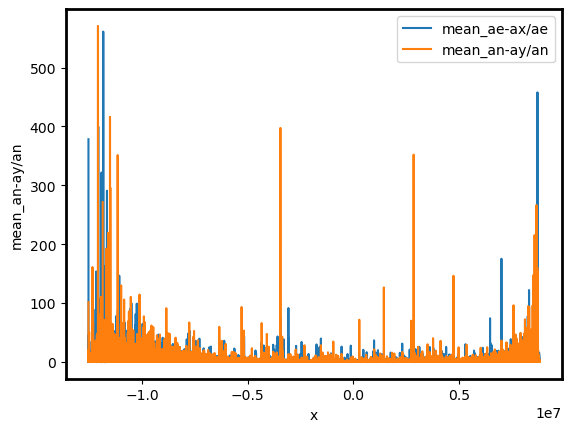

In [16]:
abs(ds_x_gps['mean_ae-ax/ae']).plot(label='mean_ae-ax/ae')
abs(ds_x_gps['mean_an-ay/an']).plot(label='mean_an-ay/an')
plt.legend()

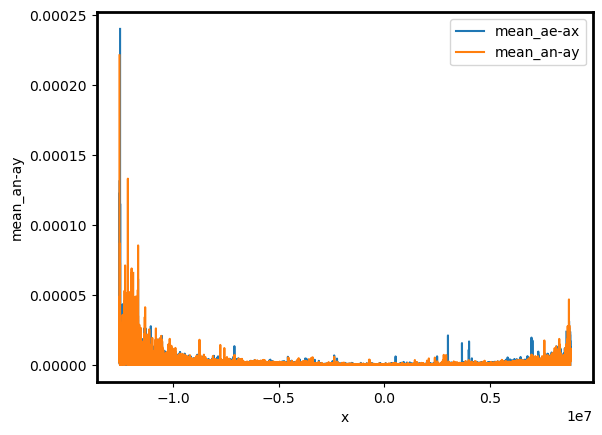

In [25]:
abs(ds_x_gps['mean_ae-ax']).plot(label='mean_ae-ax')
abs(ds_x_gps['mean_an-ay']).plot(label='mean_an-ay')
plt.legend()

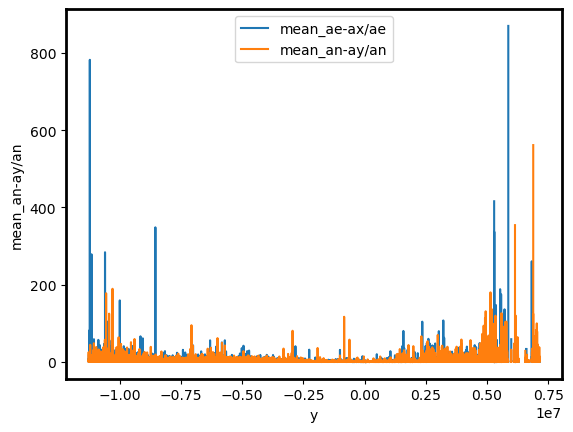

In [17]:
abs(ds_y_gps['mean_ae-ax/ae']).plot(label='mean_ae-ax/ae')
abs(ds_y_gps['mean_an-ay/an']).plot(label='mean_an-ay/an')
plt.legend()

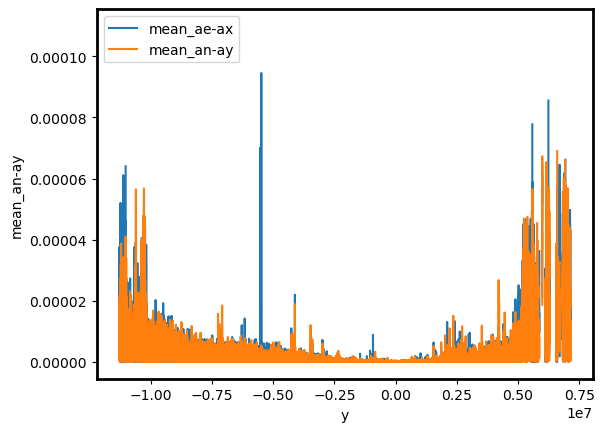

In [26]:
abs(ds_y_gps['mean_ae-ax']).plot(label='mean_ae-ax')
abs(ds_y_gps['mean_an-ay']).plot(label='mean_an-ay')
plt.legend()

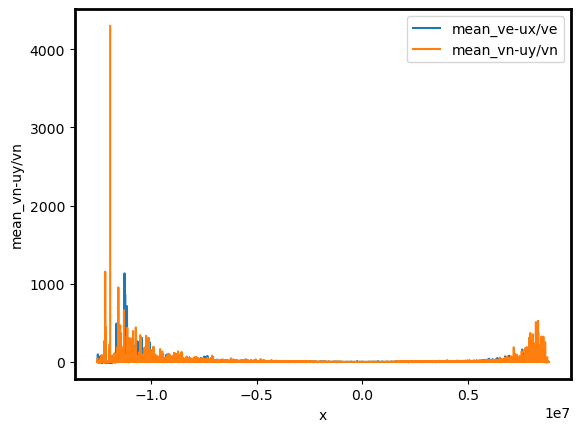

In [18]:
abs(ds_x_gps['mean_ve-ux/ve']).plot(label='mean_ve-ux/ve')
abs(ds_x_gps['mean_vn-uy/vn']).plot(label='mean_vn-uy/vn')
plt.legend()

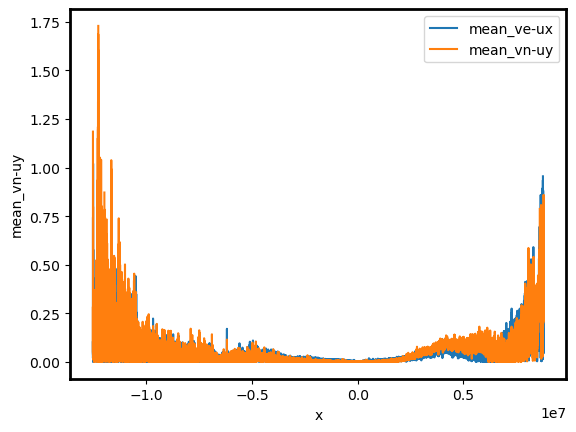

In [27]:
abs(ds_x_gps['mean_ve-ux']).plot(label='mean_ve-ux')
abs(ds_x_gps['mean_vn-uy']).plot(label='mean_vn-uy')
plt.legend()

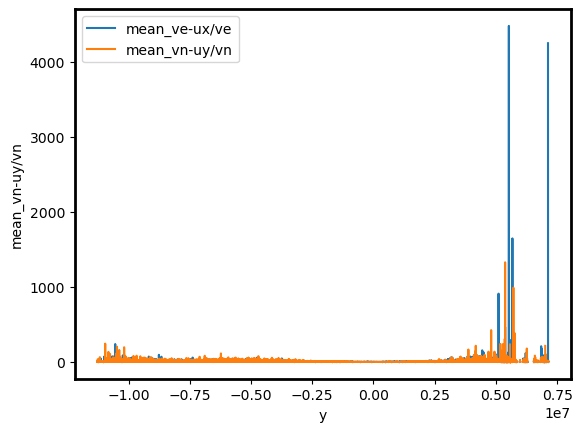

In [21]:
abs(ds_y_gps['mean_ve-ux/ve']).plot(label='mean_ve-ux/ve')
abs(ds_y_gps['mean_vn-uy/vn']).plot(label='mean_vn-uy/vn')
plt.legend()

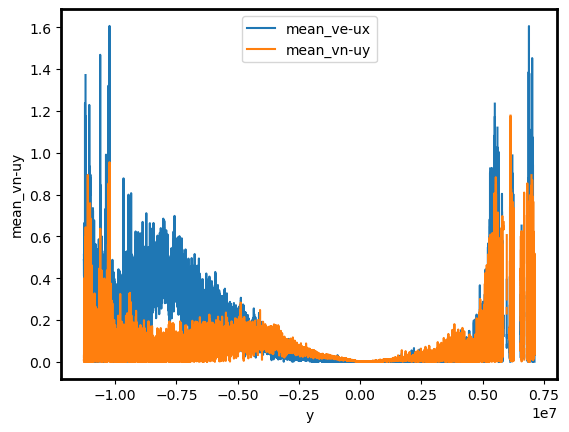

In [28]:
abs(ds_y_gps['mean_ve-ux']).plot(label='mean_ve-ux')
abs(ds_y_gps['mean_vn-uy']).plot(label='mean_vn-uy')
plt.legend()

## Diff derivation dependance on the gap

In [22]:
def deriv_dep2_gap(df):
    gap_min = (df["gap"].min()).compute()
    gap_max = (df["gap"].max()).compute()
    df['ae-ax/ae']=df['ae-ax']/df['ae']
    df['an-ay/an']=df['an-ay']/df['an']
    df['ve-ux/ve']=df['ve-ux']/df['ve']
    df['vn-uy/vn']=df['vn-uy']/df['vn']
    #delta_gap = (gap_min - t_start)/pd.Timedelta('1H')
    gap_bins = np.arange(gap_min, gap_max, 1800) # 10min binning
    df['gap_cut'] = df["gap"].map_partitions(pd.cut, gap_bins)
    mean_gap = (df[['ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']]
         .groupby(df.gap_cut)
         .mean()
         .compute()
         .rename(columns={l:'mean_'+ l for l in ['ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']})
         #.to_frame() ALREADY A DATAFRAME
        )
    mean_gap['gap'] = mean_gap.index.to_series().apply(lambda d: d.mid)
    mean_gap = mean_gap.set_index('gap')

    ds = (mean_gap
          #.drop(columns=["year",])
          .to_xarray()
         )
    ds['gap']=ds['gap']/3600 # gap in hours
    return ds

In [37]:
ds_gap_gps = deriv_dep2_gap(df_gps)

In [38]:
ds_gap_gps

<xarray.Dataset>
Dimensions:        (gap: 23)
Coordinates:
  * gap            (gap) float64 0.25 0.75 1.25 1.75 ... 9.75 10.25 10.75 11.25
Data variables:
    mean_ae-ax/ae  (gap) float64 0.007464 0.0006882 -7.729e-05 ... 0.1279 0.311
    mean_an-ay/an  (gap) float64 0.01503 0.0001313 -1.043e-05 ... 0.6388 -0.7925
    mean_ve-ux/ve  (gap) float64 0.001666 0.004553 7.786e-06 ... 0.02743 -0.1862
    mean_vn-uy/vn  (gap) float64 0.003165 0.001688 6.608e-05 ... 0.5359 -0.4002

In [6]:
abs(ds_gap_gps['mean_ae-ax/ae']).plot(label='mean_ae-ax/ae')
abs(ds_gap_gps['mean_an-ay/an']).plot(label='mean_an-ay/an')
plt.legend()

NameError: name 'ds_gap_gps' is not defined

In [7]:
abs(ds_gap_gps['mean_ve-ux/ve']).plot(label='mean_ve-ux/ve')
abs(ds_gap_gps['mean_vn-uy/vn']).plot(label='mean_vn-uy/vn')
plt.legend()

NameError: name 'ds_gap_gps' is not defined

## Diff derivation dependance on the gap

In [ ]:
df_out = df_gps[['ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']].compute()

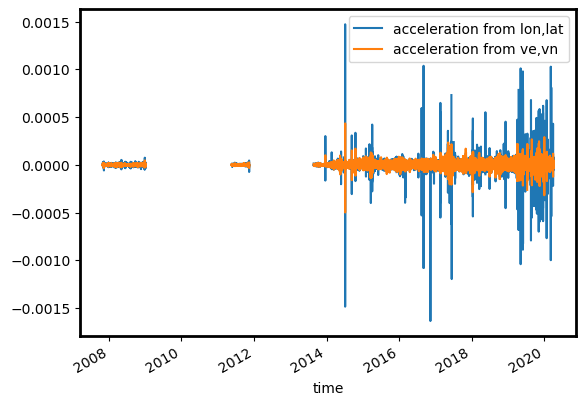

In [12]:
df_gps['acc_x'].plot(label='acceleration from lon,lat')
df_gps['ae'].plot(label='acceleration from ve,vn')
plt.legend()

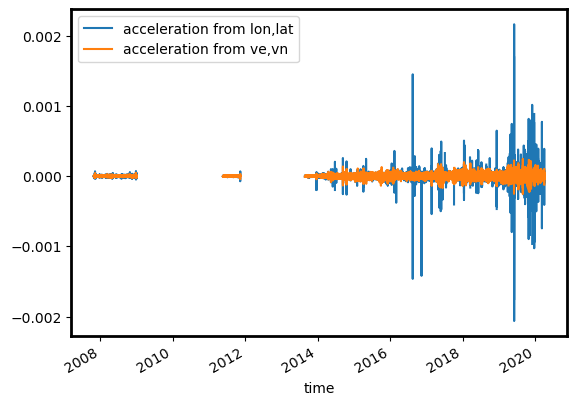

In [13]:
df_out['acc_y'].plot(label='acceleration from lon,lat')
df_out['an'].plot(label='acceleration from ve,vn')
plt.legend()

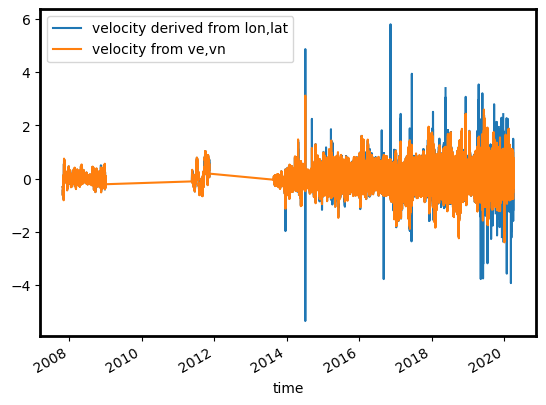

In [14]:
df_out['ux'].plot(label='velocity derived from lon,lat')
df_out['ve'].plot(label='velocity from ve,vn')
plt.legend()

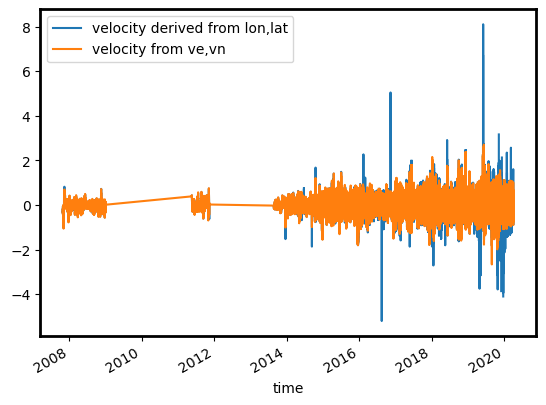

In [15]:
df_out['uy'].plot(label='velocity derived from lon,lat')
df_out['vn'].plot(label='velocity from ve,vn')
plt.legend()

In [160]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
